In [9]:
import zarr, 
dask.array as da 
xarray as xr

PATH = "/scratch2/mg963/anemoi_era5/era5-o96-1979-2023-6h-v8.zarr"

# If you’re in Jupyter, do this once per kernel to avoid asyncio complaints:
import nest_asyncio
nest_asyncio.apply()

zg = zarr.open_group(PATH, mode="r")

# Candidate coordinate arrays present in your store
COORD_CANDIDATES = ["dates", "latitudes", "longitudes"]

# Grab coord arrays that exist
coords = {}
for name in COORD_CANDIDATES:
    if name in zg:
        arr = zg[name]
        coords[name] = (name, da.from_zarr(arr))
if not coords:
    raise RuntimeError("No known coord arrays found (expected at least one of dates/latitudes/longitudes).")

# Build a length map for matching dims by size
coord_len = {k: coords[k][1].shape[0] for k in coords}

# Preference order for mapping equal sizes to a dim name
PREF_ORDER = ["dates", "latitudes", "longitudes"]

def axis_to_dim(length):
    cands = [k for k, L in coord_len.items() if L == length]
    for p in PREF_ORDER:
        if p in cands:
            return p
    return cands[0] if cands else None  # fallback

data_vars = {}
for name in zg.array_keys():
    if name in coords:  # skip coord arrays themselves
        continue
    za = zg[name]
    darr = da.from_zarr(za)  # lazy
    dims = []
    for i, ax_len in enumerate(za.shape):
        dim = axis_to_dim(ax_len) or f"dim_{i}"
        dims.append(dim)
    data_vars[name] = (dims, darr, dict(za.attrs))

ds = xr.Dataset(
    data_vars=data_vars,
    coords={k: v for k, v in coords.items()},
    attrs=dict(zg.attrs),
)

# Optional: rename coords to xarray-conventional names
rename_map = {"dates": "time", "latitudes": "latitude", "longitudes": "longitude"}
ds = ds.rename({k: v for k, v in rename_map.items() if k in ds.coords})

ds

SyntaxError: invalid syntax (1160413388.py, line 1)

In [39]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 40320)> Size: 323kB
array([ 89.284228,  89.284228,  89.284228, ..., -89.284228, -89.284228,
       -89.284228], shape=(40320,))
Coordinates:
  * latitude  (latitude) float64 323kB 89.28 89.28 89.28 ... -89.28 -89.28

In [41]:
data = ds["data"]

# # get the 1D longitude vector from the dataset (name may be 'longitude' or 'longitudes')
# lon = ds.get("longitude", ds.get("longitudes"))
# if lon is None:
#     raise KeyError("No 'longitude' or 'longitudes' array found in ds")

# # sanity check
# assert lon.size == data.sizes["latitude"], "longitude length must match data's 'latitude' axis"

# # attach as an auxiliary coord aligned to the 'latitude' dimension
# data = data.assign_coords(longitude=("latitude", lon.data))

data = data.rename({"dim_1": "feature",
             "dim_2": "number",
            "latitude": "points"      # this was the points axis, not a coord name
})

# attach coords to the points axis
data = data.assign_coords({
    "lat": ("points", ds["latitude"].data),
    "lon": ("points", ds["longitude"].data)
})

# label the stacked variable axis using the metadata list
features = ds.attrs.get("variables", None)
if features and len(features) == data.sizes["feature"]:
    data = data.assign_coords(feature=("feature", features))

data

<xarray.DataArray 'data' (time: 65744, feature: 101, number: 1, points: 40320)> Size: 1TB
dask.array<from-zarr, shape=(65744, 101, 1, 40320), dtype=float32, chunksize=(1, 101, 1, 40320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[s] 526kB 1979-01-01 ... 2023-12-31T18:00:00
  * feature  (feature) <U14 6kB '10u' '10v' '2d' ... 'z_700' 'z_850' 'z_925'
  * points   (points) float64 323kB 89.28 89.28 89.28 ... -89.28 -89.28 -89.28
    lat      (points) float64 323kB 89.28 89.28 89.28 ... -89.28 -89.28 -89.28
    lon      (points) float64 323kB 0.0 18.0 36.0 54.0 ... 306.0 324.0 342.0
Dimensions without coordinates: number

In [42]:
data.feature

<xarray.DataArray 'feature' (feature: 101)> Size: 6kB
array(['10u', '10v', '2d', '2t', 'cos_julian_day', 'cos_latitude',
       'cos_local_time', 'cos_longitude', 'cp', 'insolation', 'lsm', 'msl',
       'q_100', 'q_1000', 'q_150', 'q_200', 'q_250', 'q_300', 'q_400', 'q_50',
       'q_500', 'q_600', 'q_700', 'q_850', 'q_925', 'sdor', 'sin_julian_day',
       'sin_latitude', 'sin_local_time', 'sin_longitude', 'skt', 'slor', 'sp',
       't_100', 't_1000', 't_150', 't_200', 't_250', 't_300', 't_400', 't_50',
       't_500', 't_600', 't_700', 't_850', 't_925', 'tcw', 'tp', 'u_100',
       'u_1000', 'u_150', 'u_200', 'u_250', 'u_300', 'u_400', 'u_50', 'u_500',
       'u_600', 'u_700', 'u_850', 'u_925', 'v_100', 'v_1000', 'v_150', 'v_200',
       'v_250', 'v_300', 'v_400', 'v_50', 'v_500', 'v_600', 'v_700', 'v_850',
       'v_925', 'w_100', 'w_1000', 'w_150', 'w_200', 'w_250', 'w_300', 'w_400',
       'w_50', 'w_500', 'w_600', 'w_700', 'w_850', 'w_925', 'z', 'z_100',
       'z_1000', 'z_150', 'z_200', 'z_250', 'z_300', 'z_400', 'z_50', 'z_500',
       'z_600', 'z_700', 'z_850', 'z_925'], dtype='<U14')
Coordinates:
  * feature  (feature) <U14 6kB '10u' '10v' '2d' ... 'z_700' 'z_850' 'z_925'

In [44]:
t850 = data.sel(feature="t_850", number=0).isel(time=0)

In [48]:
ds_vars = data.squeeze("number").to_dataset(dim="feature")

In [50]:
ds_vars;

In [54]:
import geopandas as gpd
import numpy as np

# Natural Earth 110m admin-0 countries (direct zip)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

# Some NE versions name the country column 'ADMIN' (sometimes 'SOVEREIGNT' or 'NAME')
name_col = "ADMIN" if "ADMIN" in world.columns else ("SOVEREIGNT" if "SOVEREIGNT" in world.columns else "NAME")
bol_poly = world.loc[world[name_col] == "Bolivia"].to_crs("EPSG:4326").geometry.iloc[0]

# points → mask (assumes ds_vars has coords lon(points), lat(points))
to_lon180 = lambda x: ((x + 180) % 360) - 180
pts = gpd.GeoSeries.from_xy(to_lon180(ds_vars["lon"]).values, ds_vars["lat"].values, crs="EPSG:4326")
inside = pts.within(bol_poly)

ds_bolivia = ds_vars.isel(points=np.flatnonzero(inside))
ds_bolivia

<xarray.Dataset> Size: 2GB
Dimensions:         (time: 65744, points: 94)
Coordinates:
  * time            (time) datetime64[s] 526kB 1979-01-01 ... 2023-12-31T18:0...
  * points          (points) float64 752B -10.75 -10.75 -10.75 ... -21.97 -21.97
    lat             (points) float64 752B -10.75 -10.75 -10.75 ... -21.97 -21.97
    lon             (points) float64 752B 292.2 293.3 294.3 ... 295.7 296.9
Data variables: (12/101)
    10u             (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    10v             (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    2d              (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    2t              (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    cos_julian_day  (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    cos_latitude    (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    ...              ...
    z_50            (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    z_500           (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    z_600           (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    z_700           (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    z_850           (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>
    z_925           (time, points) float32 25MB dask.array<chunksize=(1, 94), meta=np.ndarray>

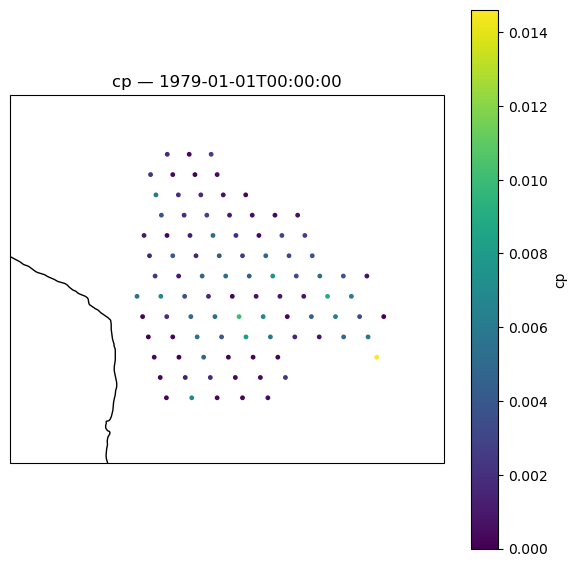

In [57]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Choose variable + timestamp
var_name = "cp"                           # <-- change as needed
var = ds_bolivia[var_name].isel(time=0)      # first time step

# Prepare figure
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent around Bolivia
ax.set_extent([-75, -55, -25, -8], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', linewidth=1)

# Native-grid scatter plot
sc = ax.scatter(
    var.lon.values,
    var.lat.values,
    c=var.values,
    s=6,
    transform=ccrs.PlateCarree()
)

# Add colorbar & title
plt.colorbar(sc, orientation="vertical", label=var.attrs.get("long_name", var_name))
plt.title(f"{var_name} — {str(var.time.values)[:19]}")
plt.show()